# Stock price prediction. 
# Final project (StonksMaster) for "10 Days of Code" by NIT Durgapur
# Plotting real-time stock data and predicting stock fluctuations using standard algorithms.

In [1]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from pprint import pprint 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
#Using iexcloud api to get the stock prices of AAPL.
df = pd.read_json('https://cloud.iexapis.com/stable/stock/aapl/chart/1y?token=pk_cc965fc3b7d94fc7b06a798c0cd96bae') 

In [3]:
df.tail(5)

,date,open,close,high,low,volume,uOpen,uClose,uHigh,uLow,uVolume,change,changePercent,label,changeOverTime
249,2020-10-05,113.91,116.50,116.65,113.55,106243839,113.91,116.50,116.65,113.55,106243839,3.48,3.0791,"Oct 5, 20",1.052592
250,2020-10-06,115.70,113.16,116.12,112.25,161498212,115.70,113.16,116.12,112.25,161498212,-3.34,-2.8670,"Oct 6, 20",0.993745
251,2020-10-07,114.62,115.08,115.55,114.13,96848985,114.62,115.08,115.55,114.13,96848985,1.92,1.6967,"Oct 7, 20",1.027573
252,2020-10-08,116.25,114.97,116.40,114.59,83477153,116.25,114.97,116.40,114.59,83477153,-0.11,-0.0956,"Oct 8, 20",1.025635
253,2020-10-09,115.28,116.97,117.00,114.92,100506865,115.28,116.97,117.00,114.92,100506865,2.00,1.7100,"Oct 9, 20",0.000000


## Here we have the dataset which contains the opening and closing prices of Apple's stocks for the a year before the current day, day wise. 
## "high" and "low" are the highest and the lowest prices for the stocks for that particular day. 
## "volume" represents the number of stocks that were bought that day. 
## "change percentage" is percentage change of the closing price with respect to the last day's closing price.  

In [4]:
df.date.dtype

dtype('<M8[ns]')

### Here the datatype of "date" column is datetime64. 

### The datetime datatype cannot be passed into a linear regression model. This happens becuase Linear Regression cannot assign coefficient to the date feature as it doesn't comprehend the datetime64 datatype well. Therefore we need is to make the datetime object as numerical value and then feed that into the model. 
### So I would take months of the year, from intuition, as my feature which relates to the date column. 

In [5]:
s = pd.to_datetime(df['date'])
df['date'] = s.dt.strftime("%Y%m")          #This returns 2020-10-2 as 202010 (YearMonth)

In [6]:
df.date = df.date.astype('int64')
df.date.dtype

dtype('int64')

In [7]:
df.tail(5)

,date,open,close,high,low,volume,uOpen,uClose,uHigh,uLow,uVolume,change,changePercent,label,changeOverTime
249,202010,113.91,116.50,116.65,113.55,106243839,113.91,116.50,116.65,113.55,106243839,3.48,3.0791,"Oct 5, 20",1.052592
250,202010,115.70,113.16,116.12,112.25,161498212,115.70,113.16,116.12,112.25,161498212,-3.34,-2.8670,"Oct 6, 20",0.993745
251,202010,114.62,115.08,115.55,114.13,96848985,114.62,115.08,115.55,114.13,96848985,1.92,1.6967,"Oct 7, 20",1.027573
252,202010,116.25,114.97,116.40,114.59,83477153,116.25,114.97,116.40,114.59,83477153,-0.11,-0.0956,"Oct 8, 20",1.025635
253,202010,115.28,116.97,117.00,114.92,100506865,115.28,116.97,117.00,114.92,100506865,2.00,1.7100,"Oct 9, 20",0.000000


In [8]:
drop_columns = ['volume', 'uOpen', 'uClose', 'uHigh', 'uLow', 
                'uVolume', 'change', 'changePercent', 'label', 'changeOverTime']
df.drop(drop_columns, axis = 1, inplace = True)
df.rename(columns = {'date':'YearMonth'})

,YearMonth,open,close,high,low
0,201910,56.76,56.76,56.95,56.41
1,201910,56.98,57.52,57.61,56.83
2,201910,58.24,59.05,59.41,58.08
3,201910,58.73,58.97,59.53,58.67
4,201910,59.10,58.83,59.41,58.72
...,...,...,...,...,...
249,202010,113.91,116.50,116.65,113.55
250,202010,115.70,113.16,116.12,112.25
251,202010,114.62,115.08,115.55,114.13
252,202010,116.25,114.97,116.40,114.59


In [9]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    254 non-null    int64  
 1   open    254 non-null    float64
 2   close   254 non-null    float64
 3   high    254 non-null    float64
 4   low     254 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 10.0 KB


None

,date,open,close,high,low
0,201910,56.76,56.76,56.95,56.41
1,201910,56.98,57.52,57.61,56.83
2,201910,58.24,59.05,59.41,58.08
3,201910,58.73,58.97,59.53,58.67
4,201910,59.10,58.83,59.41,58.72


<AxesSubplot:>

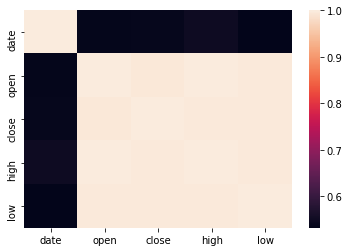

In [10]:
corr = abs(df.corr())
sns.heatmap(corr)

## The correlation map doesn't really give any useful insights apart from what we expeceted from the basic understandings stocks and terms related to it.

In [11]:
df.date = (df.date-df.date.mean())/df.date.std()        #Normalizing the YearMonth column

In [12]:
Y = df.open                                          #Separating the taget variable from the features 
df.drop('open', axis = 1, inplace = True)
X = df

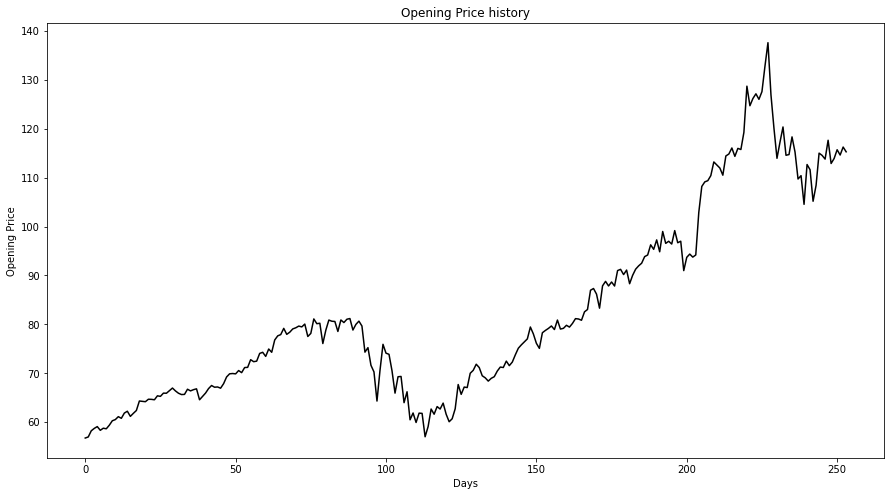

In [13]:
#Plotting history of opening prices for AAPL
plt.figure(figsize=(15,8))
plt.plot(Y, color="black")
plt.title('Opening Price history')
plt.ylabel('Opening Price')
plt.xlabel('Days')
plt.show()

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state = 14, test_size = .2)

In [15]:
models = [KNeighborsRegressor(), GradientBoostingRegressor(),
          LinearRegression(), SVR(), DecisionTreeRegressor()]
for model in models:
    kfold = KFold(n_splits=5, random_state= 14, shuffle=True)
    result = cross_val_score(model, xtrain, ytrain, 
                             cv=kfold, scoring = 'r2')
    print("For", model, "the r2 score is",result)

For KNeighborsRegressor() the r2 score is [0.99335666 0.99502475 0.99636053 0.99643137 0.99494827]
For GradientBoostingRegressor() the r2 score is [0.99508039 0.9947121  0.99403207 0.996039   0.99335516]
For LinearRegression() the r2 score is [0.99800156 0.99873292 0.99900641 0.99849952 0.99700489]
For SVR() the r2 score is [0.9342955  0.9574346  0.97237578 0.97949413 0.93715948]
For DecisionTreeRegressor() the r2 score is [0.99685413 0.99215437 0.99111943 0.99611375 0.99177949]


# Linear Regresssion 

In [16]:
lr = LinearRegression(normalize=True, copy_X=True)
lr.fit(xtrain,ytrain)
predict = lr.predict(X)

In [17]:
from sklearn import metrics
print('R^2:',metrics.r2_score(Y, predict))

R^2: 0.9982185776823383


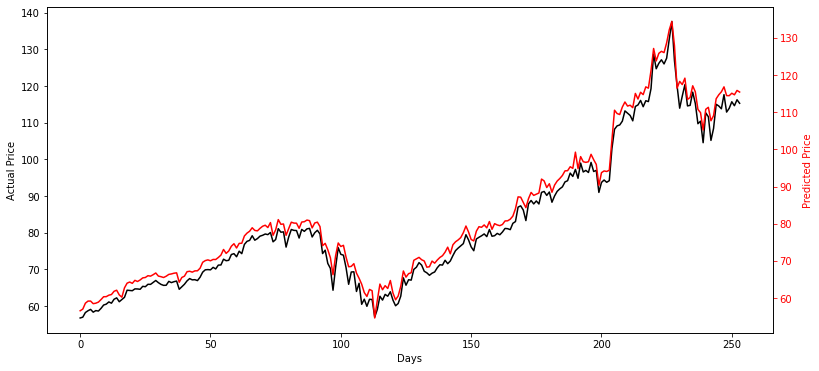

In [18]:
fig, ax1 = plt.subplots(figsize=(13,6))
ax1.set_xlabel('Days')
ax1.set_ylabel('Actual Price')
ax1.plot(Y, color = 'black')

ax2 = ax1.twinx()
ax2.set_ylabel('Predicted Price', color ='red')
ax2.tick_params(axis='y', colors='red')
ax2.plot(predict, color = 'red')
plt.show()

# Gradient Boosting Regressor 

In [19]:
gbr = GradientBoostingRegressor()
pprint(gbr.get_params())                    #Getting the hyperparameters which can be tuned for a better model

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


### Using RandomSearchCV to get range of optimum values of hyperparameters 

In [20]:
random_grid = {'n_estimators': [25,50,100,150,200,300],
               'max_depth': [3,5,10,15],
               'min_samples_leaf': [2, 3, 4],
               'learning_rate' : [.01,.03,.3,1],
               'criterion' : ['friedman_mse','mse']}
pprint(random_grid)

{'criterion': ['friedman_mse', 'mse'],
 'learning_rate': [0.01, 0.03, 0.3, 1],
 'max_depth': [3, 5, 10, 15],
 'min_samples_leaf': [2, 3, 4],
 'n_estimators': [25, 50, 100, 150, 200, 300]}


In [21]:
gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid,
                                n_iter = 100, cv = 5, random_state=14, verbose = 0)

In [22]:
gbr_random.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   param_distributions={'criterion': ['friedman_mse', 'mse'],
                                        'learning_rate': [0.01, 0.03, 0.3, 1],
                                        'max_depth': [3, 5, 10, 15],
                                        'min_samples_leaf': [2, 3, 4],
                                        'n_estimators': [25, 50, 100, 150, 200,
                                                         300]},
                   random_state=14)

In [23]:
gbr_random.best_params_                     #Best parameters found by the RandomSearchCV

{'n_estimators': 50,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'learning_rate': 0.3,
 'criterion': 'mse'}

### With small datasets and limited number of features GridSearchCV provides a very accurate model. 

In [24]:
grid_param = {'n_estimators': [150,200,100],
               'max_depth': [10,15,17,20],
               'min_samples_leaf': [3, 4,5],
               'learning_rate' : [.1,0.1,0.3],
               'criterion' : ['friedman_mse']}
pprint(grid_param)

{'criterion': ['friedman_mse'],
 'learning_rate': [0.1, 0.1, 0.3],
 'max_depth': [10, 15, 17, 20],
 'min_samples_leaf': [3, 4, 5],
 'n_estimators': [150, 200, 100]}


In [25]:
grid_search =  GridSearchCV(estimator = gbr, param_grid = grid_param, 
                          cv = 3, verbose = 0)

In [26]:
grid_search.fit(xtrain, ytrain)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.1, 0.1, 0.3],
                         'max_depth': [10, 15, 17, 20],
                         'min_samples_leaf': [3, 4, 5],
                         'n_estimators': [150, 200, 100]})

In [27]:
grid_search.best_params_                     #These are the best parameters for the Gradient Boosting Regressor 

{'criterion': 'friedman_mse',
 'learning_rate': 0.3,
 'max_depth': 17,
 'min_samples_leaf': 4,
 'n_estimators': 200}

In [33]:
gbr_final = GradientBoostingRegressor(n_estimators=200, criterion='friedman_mse', learning_rate = 0.3, 
                               max_depth=10, min_samples_leaf=4)

In [34]:
gbr_final.fit(xtrain,ytrain)

GradientBoostingRegressor(learning_rate=0.3, max_depth=10, min_samples_leaf=4,
                          n_estimators=200)

In [35]:
predict = gbr_final.predict(X)

In [36]:
from sklearn import metrics
print('R^2:',metrics.r2_score(Y, predict))

R^2: 0.9992301652977653


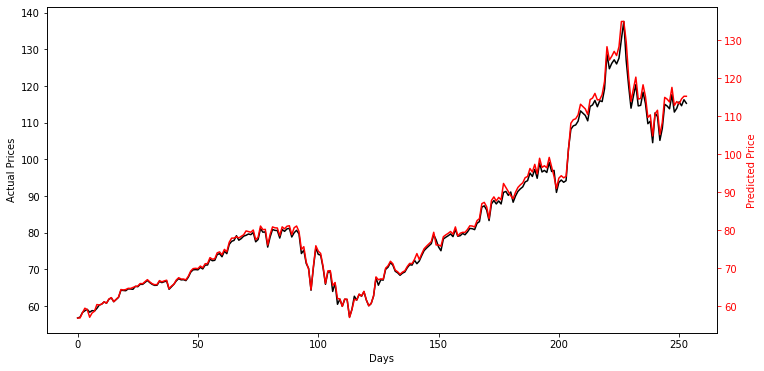

In [37]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Days')
ax1.set_ylabel('Actual Prices')
ax1.plot(Y, color = 'black')

ax2 = ax1.twinx()
ax2.set_ylabel('Predicted Price', color ='red')
ax2.plot(predict, color = 'red')
ax2.tick_params(axis='y', colors='red')
plt.show()

## Our model predicts prices pretty well based on the history of our chosen features. 